# The Toxic competition with Word Counts approach

In [1]:
import pylab as p
from numpy import *
import pandas as pd
import scipy.sparse
from tqdm import tqdm 
import xgboost as xgb
import lightgbm as lgbm
from sklearn.metrics import log_loss as sklearn_log_loss
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score as sklearn_roc_auc_score
# from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

### Read in the data

In [2]:
%%time

### Read in the TOXIC competition data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Target labels
ycols = train.columns[2:]
ys = train[ycols].values

# Single out the text
X = train.comment_text.fillna(value='unknown').values
Y = test.comment_text.fillna(value='unknown').values

print('Reading the challenge data...')
print( '%-27s %-10i' % ('Size of the training set:', len(train)))
print( '%-27s %-10i' % ('Size of the testing set:', len(test)))
print()

# Read in the lemmas
print('Loading the lemmas...')
X_lemma = load('../lemmas/X_lemma.npy')
Y_lemma = load('../lemmas/Y_lemma.npy')
# Join the lemmas
for i,v in enumerate(X_lemma):
    X_lemma[i] = ' '.join([word for word in v])
for i,v in enumerate(Y_lemma):
    Y_lemma[i] = ' '.join([word for word in v])
    
# Merge the text from the train and test sets in order to increase the vocabulary
Z_lemma = concatenate((X_lemma, Y_lemma))
Z = concatenate((train.comment_text.values, test.comment_text.values))

Reading the challenge data...
Size of the training set:   159571    
Size of the testing set:    153164    

Loading the lemmas...
CPU times: user 2.6 s, sys: 296 ms, total: 2.9 s
Wall time: 2.9 s


### Building features from word counts

In [3]:
%%time

# Define the vectorizers
vectorizer11 = TfidfVectorizer(ngram_range=(1,1), analyzer='word', max_features=20000, dtype=float32)
vectorizer12 = TfidfVectorizer(ngram_range=(1,2), analyzer='word', max_features=20000, dtype=float32)
vectorizer13 = TfidfVectorizer(ngram_range=(1,3), analyzer='word', max_features=20000, dtype=float32)
vectorizer15 = TfidfVectorizer(ngram_range=(1,5), analyzer='char', max_features=20000, dtype=float32)

# Fit the vectorizes
print('Fitting vectorizer11...')
vectorizer11.fit(Z_lemma)
print('Fitting vectorizer12...')
vectorizer12.fit(Z_lemma)
print('Fitting vectorizer13...')
vectorizer13.fit(Z_lemma)
print('Fitting vectorizer15...')
vectorizer15.fit(Z)
print('Fitting of the vectorizers is now complete.')
print('')

# Transformations
print('Transforming the training set...')
Xwv11 = vectorizer11.transform(X_lemma)
Xwv12 = vectorizer12.transform(X_lemma)
Xwv13 = vectorizer13.transform(X_lemma)
Xwv15 = vectorizer15.transform(X)
print('Transforming the testing set...')
Ywv11 = vectorizer11.transform(Y_lemma)
Ywv12 = vectorizer12.transform(Y_lemma)
Ywv13 = vectorizer13.transform(Y_lemma)
Ywv15 = vectorizer15.transform(Y)

print('')
print('Combining the features from all vectorizers...')
Xtrain = scipy.sparse.hstack([Xwv11, Xwv12, Xwv13, Xwv15])
Ytrain = scipy.sparse.hstack([Ywv11, Ywv12, Ywv13, Ywv15])
print('Converting to CSR matrix format')
Xtrain = Xtrain.tocsr()
Ytrain = Ytrain.tocsr()

Fitting vectorizer11...
Fitting vectorizer12...
Fitting vectorizer13...
Fitting vectorizer15...
Fitting of the vectorizers is now complete.

Transforming the training set...
Transforming the testing set...

Combining the features from all vectorizers...
Converting to CSR matrix format
CPU times: user 9min 28s, sys: 12.8 s, total: 9min 41s
Wall time: 9min 41s


## The `xgboost` classifier

In [4]:
# My own xgboost model class, useful for training stuff on the fly, with x-validations and all

class xgboost_model():
    def __init__(self, X, Y):
        '''
        params:
        X = dMatrix for the complete training set
        Y = dMatric for the complete test set
        '''
        self.X = X
        self.Y = Y
        
    def run_xgboost_model(self, params, num_boost_round, num_folds=5, verbose_eval=False, show_plot=True):
        
        # The KFold object
        kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
        
        # The history for the plots
        hh = tmp = [{} for _ in range(num_folds)]
        
        # metrics
        val_loss = zeros(num_folds)
        val_roc = zeros(num_folds)
        
        # predictions on the validation set
        vvpred = zeros(num_folds, dtype='O')
        
        # The test results predictions from each fold
        pred = zeros((num_folds, 153164))
        
        # The training the KFold x-validation starts here
        for i, (ind_train, ind_val) in enumerate(kf.split(self.X.get_label())):
            XX, VV = self.X.slice(ind_train), self.X.slice(ind_val)
            
            # The booster model for the given data
            booster = xgb.train(params=params, 
                                dtrain=XX, 
                                num_boost_round=num_boost_round, 
                                evals=[(XX,'train'),(VV,'val')], 
                                evals_result=hh[i],
                                early_stopping_rounds=17,
                                learning_rates=self.learning_rate_decay,
                                verbose_eval=verbose_eval)
            
            # Predictions on the validation set
            vvpred[i] = booster.predict(VV)
                        
            # Record the metrics
            val_loss[i] = sklearn_log_loss(VV.get_label(), vvpred[i])
            val_roc[i] = sklearn_roc_auc_score(VV.get_label(), vvpred[i])
            
            # Predictions onthe test set
            pred[i] = booster.predict(self.Y)

        # Plot the loss function as a diagnostic
        if show_plot:
            p.figure(figsize=(9,6))
            for i in range(num_folds):
                p.plot((hh[i]['train']['logloss']), lw=2, ls='solid')
                p.plot((hh[i]['val']['logloss']), lw=2, ls='dashed')
            p.show()
        
        # Collect the results
        mean_val_loss = val_loss.mean()
        mean_val_roc  = val_roc.mean()
        print()
        print('Average logloss across the x-validation folds: %f2.6' % (mean_val_loss))
        print('Average roc-auc across the x-validation folds: %f2.6' % (mean_val_roc))
        
        # Stack the predictions from the validation and test sets
        vvpred = hstack(vvpred)
        pred = pred.mean(axis=0)
        
        return vvpred, pred

    def learning_rate_decay(self, i, itotal):
        if (i<=10):
            lr = 0.2
        elif (10<i) & (i<=100):
            lr = 0.1
        elif (100<i) & (i<=300):
            lr = 0.05
        elif (300<i) & (i<=500):
            lr =  0.01
        elif (500<i) & (i<=1000):
            lr = 0.005
        else:
            lr = 0.001

        return lr


Predicting toxic comments


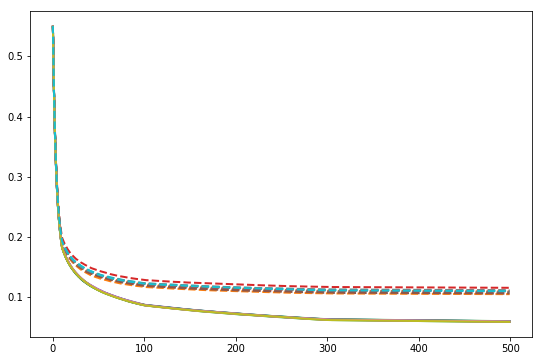


Average logloss across the x-validation folds: 0.1092272.6
Average roc-auc across the x-validation folds: 0.9717672.6


Predicting severe_toxic comments


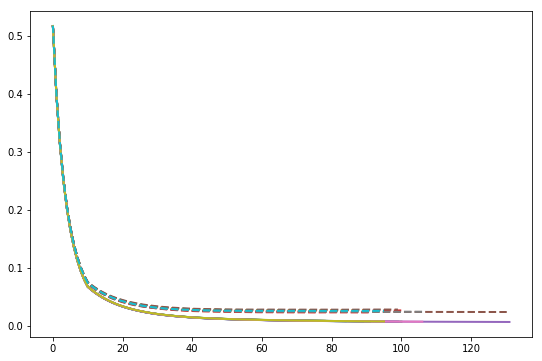


Average logloss across the x-validation folds: 0.0262302.6
Average roc-auc across the x-validation folds: 0.9843642.6


Predicting obscene comments


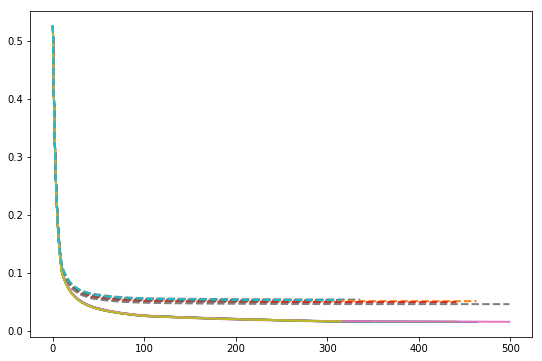


Average logloss across the x-validation folds: 0.0516472.6
Average roc-auc across the x-validation folds: 0.9903182.6


Predicting threat comments


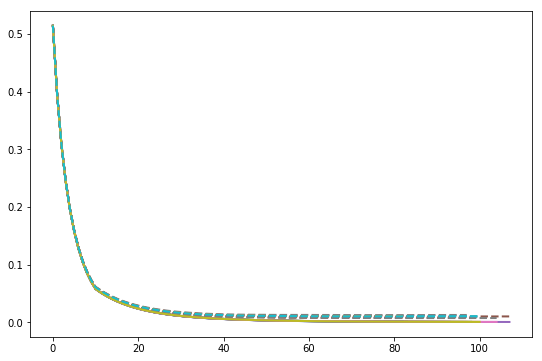


Average logloss across the x-validation folds: 0.0102712.6
Average roc-auc across the x-validation folds: 0.9806822.6


Predicting insult comments


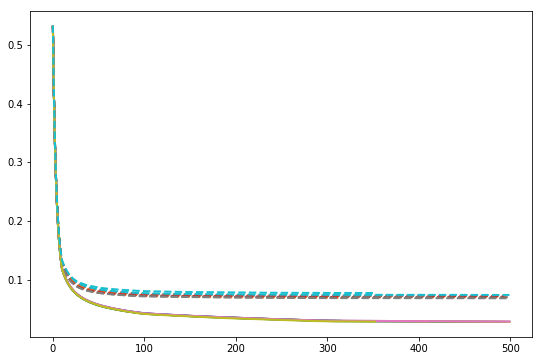


Average logloss across the x-validation folds: 0.0712652.6
Average roc-auc across the x-validation folds: 0.9797282.6


Predicting identity_hate comments


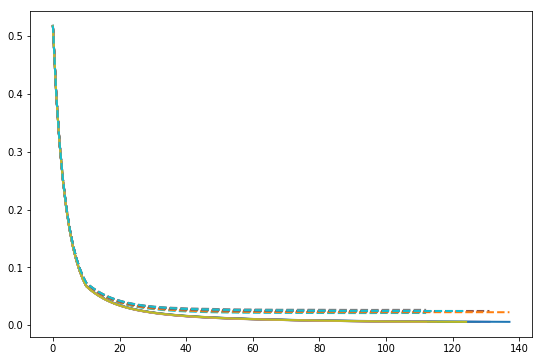


Average logloss across the x-validation folds: 0.0241062.6
Average roc-auc across the x-validation folds: 0.9763312.6



Saving the final results to disk...
All done!

CPU times: user 5d 20h 32min 44s, sys: 8min 48s, total: 5d 20h 41min 33s
Wall time: 18h 1min 41s


In [5]:
%%time

# This cell runs the xgboost_model across the full toxic dataset

# The parameters for the training process
params = {
    'max_depth': 7,
    'learning_rate': 0.2,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 1.0, # subsample ratio of columns when constructing each tree.
    'colsample_bylevel' :0.8,  # subsample ratio of columns for each split, in each level.
    'reg_lambda': 0.5,         # L2 norm
    'reg_alpha:': 1.5,         # L1 norm
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# This is where the outputs are stored
xgb_vvpred = zeros((len(ycols), Xtrain.shape[0]))
xgb_pred   = zeros((len(ycols), Ytrain.shape[0]))

# Converting the test set to xgboost friendly format
dtest  = xgb.DMatrix(data=Ytrain)

for i,v in enumerate(ycols):
    print('Predicting %s comments' % (v))
    # Converting the training set to xgboost friendly format 
    dtrain = xgb.DMatrix(data=Xtrain, label=ys[:,i])
    # instantiating my own xgboost_model class
    booster = xgboost_model(X=dtrain, Y=dtest)
    xgb_vvpred[i], xgb_pred[i] = booster.run_xgboost_model(params=params, num_boost_round=500, num_folds=10)
    print('')
    print('')

print('')
print('Saving the final results to disk...')
# Save to disk the prediction for the training set from the x-validation folds
df_valid = train.copy()
df_valid[ycols] = pd.DataFrame(xgb_vvpred.T, columns=ycols)
df_valid.to_csv('./results/xgb_xval.csv', index=False)

# Creating the submission file
submission = pd.read_csv('../sample_submission.csv')
submission[ycols] = pd.DataFrame(xgb_pred.T, columns=ycols)
submission.to_csv('./results/xgb_submission.csv', index=False)
print('All done!')
print('')

## The `LightGBM` classifier

In [ ]:
# class lgbm_model():
#     def __init__(self, X, label, Y):
#         '''
#         params:
#         X     = sparse matrix csr format (training set)
#         label = 1-d array, same length as X, the target value
#         Y     = sparse matrix csr format (test set)
#         '''
#         self.X     = X
#         self.label = label
#         self.Y     = Y
    
#     def run_lgbm_model(self, params, num_boost_round, num_folds=5, verbose_eval=False, show_plot=True):
        
#         # The KFold object
#         kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
        
#         # The history for the plots
#         hh = tmp = [{} for _ in range(num_folds)]
        
#         # metrics
#         val_loss = zeros(num_folds)
#         val_roc = zeros(num_folds)
        
#         # predictions on the validation set
#         vvpred = zeros(num_folds, dtype='O')
        
#         # The test results predictions from each fold
#         pred = zeros((num_folds, 153164))
        
#         # The training the KFold x-validation starts here
#         for i, (ind_train, ind_val) in enumerate(kf.split(self.X)):
#             XX, VV = self.X[ind_train], self.X[ind_val]
#             yx, yv = self.label[ind_train], self.label[ind_val]
            
#             # Convert the training and validation set into the lgbm format
#             dtrain = lgbm.Dataset(data=XX, label=yx)
#             dval   = lgbm.Dataset(data=VV, label=yv)
            
#             # The booster model for the given data
#             booster = lgbm.train(params=params, 
#                                  train_set=dtrain, 
#                                  num_boost_round=num_boost_round, 
#                                  valid_sets=[dtrain,dval],
#                                  valid_names=['train','val'],
#                                  evals_result=hh[i],
#                                  learning_rates=self.learning_rate_decay,
#                                  early_stopping_rounds=17,
#                                  verbose_eval=verbose_eval)
            
            
#             # Predictions on the validation set
#             vvpred[i] = booster.predict(VV)
                        
#             # Record the metrics
#             val_loss[i] = sklearn_log_loss(yv, vvpred[i])
#             val_roc[i] = sklearn_roc_auc_score(yv, vvpred[i])
            
#             # Predictions onthe test set
#             pred[i] = booster.predict(self.Y)

#         # Plot the loss function as a diagnostic
#         if show_plot:
#             p.figure(figsize=(9,6))
#             for i in range(num_folds):
#                 p.plot((hh[i]['train']['binary_logloss']), lw=2, ls='solid')
#                 p.plot((hh[i]['val']['binary_logloss']), lw=2, ls='dashed')
#             p.show()
        
#         # Collect the results
#         print()
#         print('Average logloss across the x-validation folds: %f2.6' % (val_loss.mean()))
#         print('Average roc-auc across the x-validation folds: %f2.6' % (val_roc.mean()))
        
#         # Stack the predictions from the validation and test sets
#         vvpred = hstack(vvpred)
#         pred = pred.mean(axis=0)
        
#         return vvpred, pred

#     def learning_rate_decay(self,i):        
#         if (i<=10):
#             lr = 0.2
#         elif (10<i) & (i<=100):
#             lr = 0.1
#         elif (100<i) & (i<=300):
#             lr = 0.05
#         elif (300<i) & (i<=500):
#             lr =  0.01
#         elif (500<i) & (i<=1000):
#             lr = 0.005
#         else:
#             lr = 0.001

#         return lr



In [ ]:
%%time

# This cell runs the full LightGBM model accross the entire toxic dataset

# The parameters for the training process
params = {
    'boosting': 'gbdt',
    'max_depth': 5,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'application': 'binary',
    'metric': 'binary_logloss',
    'num_threads': 8,
    'min_data_in_leaf': 20,
    'subsample': 0.80,
    'colsample_bytree': 0.80,
    'reg_lambda': 0.5,
    'reg_alpha': 1.5,
}

# This is where the outputs are stored
lgbm_vvpred = zeros((len(ycols), Xtrain.shape[0]))
lgbm_pred   = zeros((len(ycols), Ytrain.shape[0]))


for i,v in enumerate(ycols):
    print('Predicting %s comments' % (v))
    # instantiating my own lgbm_model class
    booster = lgbm_model(X=Xtrain, label=ys[:,i],  Y=Ytrain)
    lgbm_vvpred[i], lgbm_pred[i] = booster.run_lgbm_model(params=params, num_boost_round=500, num_folds=8)
    print('')
    print('')

print('')
print('Saving the final results to disk...')
# Save to disk the prediction for the training set from the x-validation folds
df_valid = train.copy()
df_valid[ycols] = pd.DataFrame(lgbm_vvpred.T, columns=ycols)
df_valid.to_csv('./results/lgbm_xval.csv', index=False)

# Creating the submission file
submission = pd.read_csv('../sample_submission.csv')
submission[ycols] = pd.DataFrame(lgbm_pred.T, columns=ycols)
submission.to_csv('./results/lgbm_submission.csv', index=False)
print('All done!')
print('')

## The `Random Forest` classifier

In [ ]:
# class rf_model():
#     def __init__(self, X, label, Y):
#         '''
#         params:
#         X     = sparse matrix csr format (training set)
#         label = 1-d array, same length as X, the target value
#         Y     = sparse matrix csr format (test set)
#         '''
#         self.X     = X
#         self.label = label
#         self.Y     = Y
        
#     def run_rf_model(self, params, num_folds=5, verbose=0):
        
#         # The KFold object
#         kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
                
#         # metrics
#         val_loss = zeros(num_folds)
#         val_roc = zeros(num_folds)
        
#         # predictions on the validation set
#         vvpred = zeros(num_folds, dtype='O')
        
#         # The test results predictions from each fold
#         pred = zeros((num_folds, 153164))
        
#         # The training the KFold x-validation starts here
#         for i, (ind_train, ind_val) in enumerate(kf.split(self.X)):
#             XX, VV = self.X[ind_train], self.X[ind_val]
#             yx, yv = self.label[ind_train], self.label[ind_val]
            
            
#             # The Random Forest model
#             model = RandomForestClassifier(n_estimators=params['n_estimators'], 
#                                            criterion=params['criterion'], 
#                                            max_depth=params['max_depth'],
#                                            min_samples_leaf=params['min_samples_leaf'],
#                                            min_samples_split=params['min_samples_split'], 
#                                            min_weight_fraction_leaf=params['min_weight_fraction_leaf'],
#                                            max_features=params['max_features'], 
#                                            n_jobs=params['n_jobs'],
#                                            verbose=verbose,
#                                            random_state=42)
            
#             # Fitting the Random Forest model
#             model.fit(XX, yx)
        
#             # Predictions on the validation set
#             vvpred[i] = model.predict_proba(VV)[:,1]
                        
#             # Record the metrics
#             val_loss[i] = sklearn_log_loss(yv, vvpred[i])
#             val_roc[i] = sklearn_roc_auc_score(yv, vvpred[i])
            
#             # Predictions onthe test set
#             pred[i] = model.predict_proba(self.Y)[:,1]

#         # Collect the results
#         print()
#         print('Average logloss across the x-validation folds: %f2.6' % (val_loss.mean()))
#         print('Average roc-auc across the x-validation folds: %f2.6' % (val_roc.mean()))
        
#         # Stack the predictions from the validation and test sets
#         vvpred = hstack(vvpred)
#         pred = pred.mean(axis=0)
        
#         return vvpred, pred


In [ ]:
# %%time

# # This cell runs the Random Forest model

# # The parameters for the Random Forest classifier
# params = {'n_estimators': 300,
#           'criterion': 'entropy',
#           'max_depth': 7,
#           'min_samples_leaf': 1,
#           'min_samples_split': 2,
#           'min_weight_fraction_leaf': 0.0, 
#           'max_features': None,
#           'n_jobs': -1, 
# }

# # This is where the outputs are stored
# rf_vvpred = zeros((len(ycols), Xtrain.shape[0]))
# rf_pred   = zeros((len(ycols), Ytrain.shape[0]))


# for i,v in enumerate(ycols):
#     print('Predicting %s comments' % (v))
#     # instantiating my own lgbm_model class
#     model = rf_model(X=Xtrain, label=ys[:,i],  Y=Ytrain)
#     rf_vvpred[i], rf_pred[i] = model.run_rf_model(params=params, num_folds=8, verbose=0)
#     print('')
#     print('')


# print('Saving the final results to disk...')
# # Save to disk the prediction for the training set from the x-validation folds
# df_valid = train.copy()
# df_valid[ycols] = pd.DataFrame(rf_vvpred.T, columns=ycols)
# df_valid.to_csv('./results/rf_xval.csv', index=False)

# # Creating the submission file
# submission = pd.read_csv('../sample_submission.csv')
# submission[ycols] = pd.DataFrame(rf_pred.T, columns=ycols)
# submission.to_csv('./results/rf_submission.csv', index=False)
# print('All done!')
# print('')

## The `Extra Trees` Classifier

In [ ]:
# class et_model():
#     def __init__(self, X, label, Y):
#         '''
#         params:
#         X     = sparse matrix csr format (training set)
#         label = 1-d array, same length as X, the target value
#         Y     = sparse matrix csr format (test set)
#         '''
#         self.X     = X
#         self.label = label
#         self.Y     = Y
        
#     def run_et_model(self, params, num_folds=5, verbose=0):
        
#         # The KFold object
#         kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
                
#         # metrics
#         val_loss = zeros(num_folds)
#         val_roc = zeros(num_folds)
        
#         # predictions on the validation set
#         vvpred = zeros(num_folds, dtype='O')
        
#         # The test results predictions from each fold
#         pred = zeros((num_folds, 153164))
        
#         # The training the KFold x-validation starts here
#         for i, (ind_train, ind_val) in enumerate(kf.split(self.X)):
#             XX, VV = self.X[ind_train], self.X[ind_val]
#             yx, yv = self.label[ind_train], self.label[ind_val]
            
            
#             # The Extra Trees Classifier
#             model = ExtraTreesClassifier(n_estimators=params['n_estimators'], 
#                                          criterion=params['criterion'], 
#                                          max_depth=params['max_depth'],
#                                          min_samples_leaf=params['min_samples_leaf'],
#                                          min_samples_split=params['min_samples_split'], 
#                                          min_weight_fraction_leaf=params['min_weight_fraction_leaf'],
#                                          max_features=params['max_features'], 
#                                          n_jobs=params['n_jobs'],
#                                          verbose=verbose,
#                                          random_state=42)
            
#             # Fitting the Random Forest model
#             model.fit(XX, yx)
        
#             # Predictions on the validation set
#             vvpred[i] = model.predict_proba(VV)[:,1]
                        
#             # Record the metrics
#             val_loss[i] = sklearn_log_loss(yv, vvpred[i])
#             val_roc[i] = sklearn_roc_auc_score(yv, vvpred[i])
            
#             # Predictions onthe test set
#             pred[i] = model.predict_proba(self.Y)[:,1]

#         # Collect the results
#         print()
#         print('Average logloss across the x-validation folds: %f2.6' % (val_loss.mean()))
#         print('Average roc-auc across the x-validation folds: %f2.6' % (val_roc.mean()))
        
#         # Stack the predictions from the validation and test sets
#         vvpred = hstack(vvpred)
#         pred = pred.mean(axis=0)
        
#         return vvpred, pred


In [ ]:
# %%time

# # This cell runs the Extra Trees Classifier

# # The parameters for the Extra Trees Classifier
# params = {'n_estimators': 300,
#           'criterion': 'entropy',
#           'max_depth': 7,
#           'min_samples_leaf': 1,
#           'min_samples_split': 2,
#           'min_weight_fraction_leaf': 0.0, 
#           'max_features': None,
#           'n_jobs': -1, 
# }

# # This is where the outputs are stored
# et_vvpred = zeros((len(ycols), Xtrain.shape[0]))
# et_pred   = zeros((len(ycols), Ytrain.shape[0]))


# for i,v in enumerate(ycols):
#     print('Predicting %s comments' % (v))
#     # instantiating my own lgbm_model class
#     model = et_model(X=Xtrain, label=ys[:,i],  Y=Ytrain)
#     et_vvpred[i], et_pred[i] = model.run_et_model(params=params, num_folds=8, verbose=0)
#     print('')
#     print('')

# print('Saving the final results to disk...')
# # Save to disk the prediction for the training set from the x-validation folds
# df_valid = train.copy()
# df_valid[ycols] = pd.DataFrame(et_vvpred.T, columns=ycols)
# df_valid.to_csv('./results/et_xval.csv', index=False)

# # Creating the submission file
# submission = pd.read_csv('../sample_submission.csv')
# submission[ycols] = pd.DataFrame(et_pred.T, columns=ycols)
# submission.to_csv('./results/et_submission.csv', index=False)
# print('All done!')
# print('')